## Multi-class PyTorch model


tensor([[-7.0811, -5.6639],
        [-9.1839,  5.9372],
        [-8.0885,  5.2246],
        [ 5.6568,  1.2413],
        [ 7.7321,  3.7857]]) tensor([2, 3, 3, 1, 1])


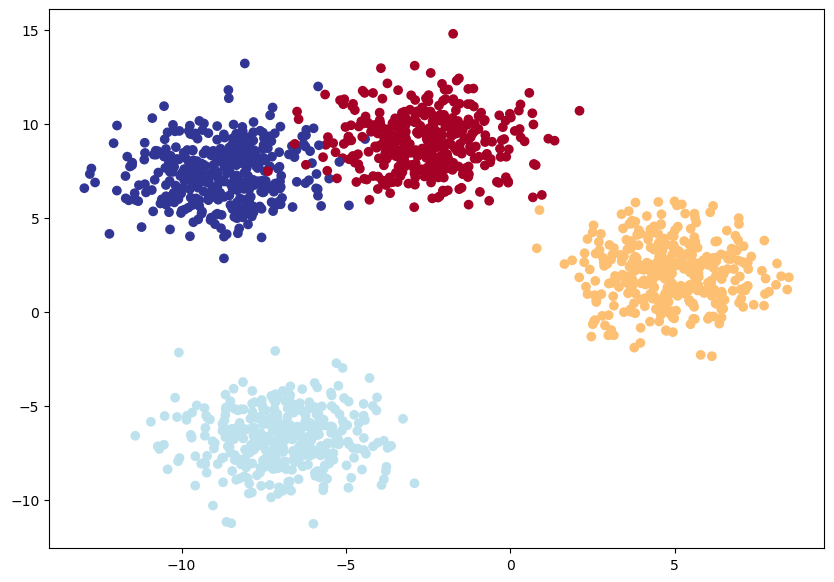

In [2]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1500,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);


> **Question:** Does this dataset need non-linearity? Or could you draw a succession of straight lines to separate it?

In [3]:
import numpy as np

# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### 2 Building a multi-class classification model in PyTorch

Let's create a subclass of `nn.Module` that takes in three hyperparameters:
* `input_features` - the number of `X` features coming into the model.
* `output_features` - the ideal numbers of output features we'd like (this will be equivalent to `NUM_CLASSES` or the number of classes in your multi-class classification problem).
* `hidden_units` - the number of hidden neurons we'd like each hidden layer to use.


In [4]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=2):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=2).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=4, bias=True)
  )
)


### 3 Creating a loss function and optimizer for a multi-class PyTorch model

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our `model_4` parameters.


In [6]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

### 4 Getting prediction probabilities for a multi-class PyTorch model


In [7]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.4870, -0.1317,  0.2177,  0.5880],
        [ 0.3631,  0.0362,  0.2740,  0.1822],
        [ 1.0763, -0.9428, -0.0642,  2.5673],
        [ 0.3013,  0.1195,  0.3017, -0.0186],
        [ 1.0048, -0.8433, -0.0289,  2.3231]], grad_fn=<SliceBackward0>)

In [8]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

Flow: `logits -> prediction probabilities -> prediction labels` 

In [9]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.7199, -0.4575,  0.1004,  1.3907],
        [ 0.4921, -0.1415,  0.2121,  0.6162],
        [-0.1114,  0.6761,  0.4863, -1.3601],
        [ 0.6697, -0.3825,  0.1311,  1.1991],
        [ 0.8841, -0.6815,  0.0241,  1.9343]], grad_fn=<SliceBackward0>)
tensor([[0.2630, 0.0810, 0.1416, 0.5144],
        [0.2925, 0.1552, 0.2211, 0.3312],
        [0.1886, 0.4145, 0.3428, 0.0541],
        [0.2754, 0.0962, 0.1607, 0.4677],
        [0.2227, 0.0465, 0.0942, 0.6365]], grad_fn=<SliceBackward0>)


In [10]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [11]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2630, 0.0810, 0.1416, 0.5144], grad_fn=<SelectBackward0>)
tensor(3)


### 5 Creating a training and testing loop for a multi-class PyTorch model


In [12]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

loss_Ar = []

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    #add result of loss to array
    loss_Ar.append(loss.item())
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.24180, Acc: 25.75% | Test Loss: 1.13876, Test Acc: 50.33%
Epoch: 10 | Loss: 0.80094, Acc: 39.08% | Test Loss: 0.78081, Test Acc: 40.33%
Epoch: 20 | Loss: 0.55986, Acc: 53.08% | Test Loss: 0.51257, Test Acc: 58.67%
Epoch: 30 | Loss: 0.24894, Acc: 99.08% | Test Loss: 0.21006, Test Acc: 98.67%
Epoch: 40 | Loss: 0.11593, Acc: 98.92% | Test Loss: 0.09664, Test Acc: 99.33%
Epoch: 50 | Loss: 0.07764, Acc: 98.92% | Test Loss: 0.06348, Test Acc: 99.33%
Epoch: 60 | Loss: 0.06126, Acc: 99.00% | Test Loss: 0.04928, Test Acc: 99.00%
Epoch: 70 | Loss: 0.05245, Acc: 99.00% | Test Loss: 0.04179, Test Acc: 99.00%
Epoch: 80 | Loss: 0.04708, Acc: 99.00% | Test Loss: 0.03734, Test Acc: 99.00%
Epoch: 90 | Loss: 0.04352, Acc: 99.00% | Test Loss: 0.03449, Test Acc: 99.00%


### 6 Making and evaluating predictions with a PyTorch multi-class model


In [13]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  3.2086,  -6.8649,   1.7424,   8.7148],
        [  2.3629,   5.6921,  -5.4077,  -4.7406],
        [ -7.2868,  -7.6863,  13.3186,   5.7181],
        [  5.0607,   8.7383, -10.1986,  -6.9380],
        [  5.2423,  -6.9485,  -0.3454,   9.5496],
        [ -6.3189,  -7.8667,  12.4150,   6.2626],
        [  7.1404,   0.6963,  -7.2388,   2.2445],
        [ -8.7012,  -6.2411,  13.8825,   3.6855],
        [ -7.6555, -13.1309,  17.1931,  11.2820],
        [ -7.6527,  -8.8748,  14.4649,   6.8278]])

> **Note:** It's possible to skip the `torch.softmax()` function and go straight from `predicted logits -> predicted labels` by calling `torch.argmax()` directly on the logits.
>
> For example, `y_preds = torch.argmax(y_logits, dim=1)`, this saves a computation step (no `torch.softmax()`) but results in no prediction probabilities being available to use. 

In [14]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([3, 1, 2, 1, 3, 2, 0, 2, 2, 2])
Labels: tensor([3, 1, 2, 1, 3, 2, 0, 2, 2, 2])
Test accuracy: 99.0%


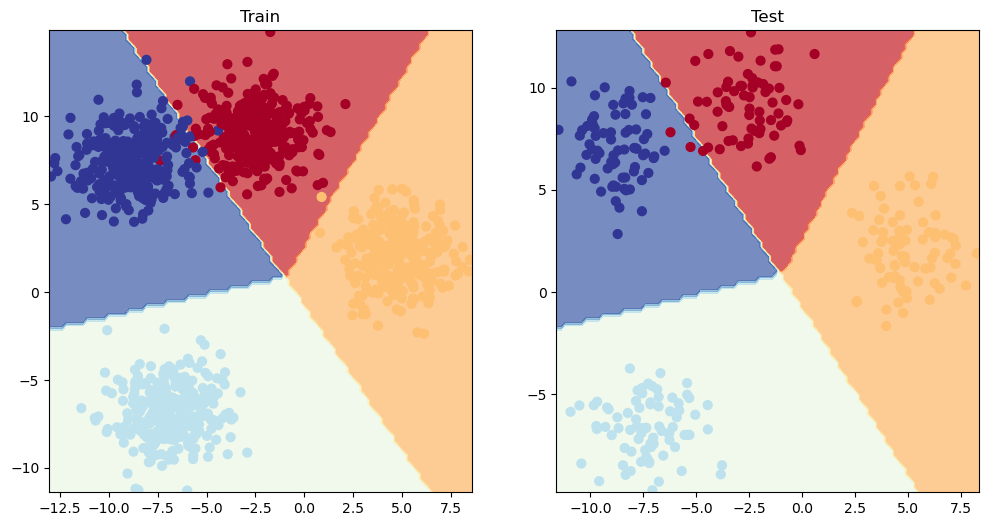

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

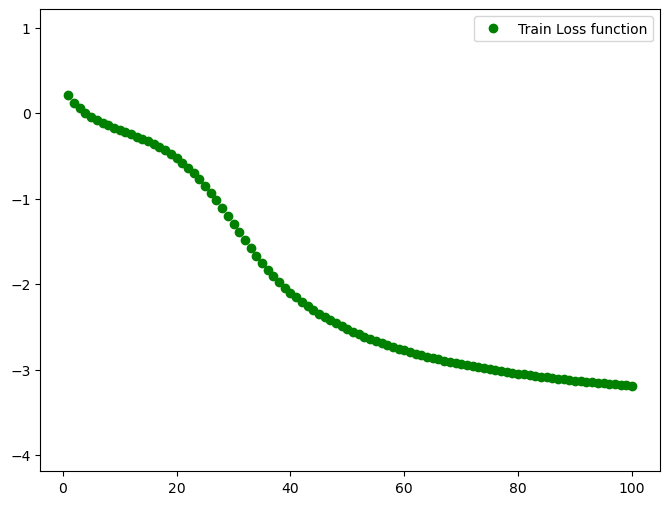

In [16]:
#print(np.log(loss_Ar))
num = [i for i in range(1, len(loss_Ar) + 1)]
#num_test = [i for i in range(1, len(loss_arr_test) + 1)]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(num,  np.log(loss_Ar), "o", label="Train Loss function", color="green")
#ax.plot(num_test, loss_arr_test, "o", label="Test Loss function", color="red")
plt.ylim(min(np.log(loss_Ar)) - 1, max(np.log(loss_Ar)) + 1)
ax.legend(loc="best")
#plt.savefig("loss_arr_true.png")
plt.show()
plt.close('all')